In [2]:
import pandas as pd
import numpy as np
import os 
import mlflow

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression, Ridge
#from sklearn.metrics import accuracy_score, root_mean_squared_error, mutual_info_score


In [3]:
cwd = os.getcwd()

path_cross = cwd+'/data/oasis_cross-sectional.csv'
path_long = cwd+'/data/oasis_longitudinal.csv'

df_cross = pd.read_csv(path_cross,sep=",", engine="python", on_bad_lines="skip") 
df_long = pd.read_csv(path_long,sep=",", engine="python", on_bad_lines="skip") 

#cleaning columns
df_cross.columns = df_cross.columns.str.replace(' ', '_').str.lower()
df_long.columns = df_long.columns.str.replace(' ', '_').str.lower()

new_column_names = {
                    'subject_id': 'id',
                    'mr_delay': 'delay'
                    }

df_long.rename(columns=new_column_names, inplace=True)

new_column_order = ['id', 'm/f', 'hand', 'age', 'educ', 'ses', 'mmse', 'cdr', 'etiv',
        'nwbv', 'asf', 'delay', 'mri_id', 'group', 'visit']

df_long = df_long[new_column_order]

df = pd.merge(df_cross, df_long, on=['id', 'm/f', 'hand', 'age', 'educ', 'ses', 'mmse', 'cdr', 'etiv',
        'nwbv', 'asf', 'delay'], how='outer')

df

,id,m/f,hand,age,educ,ses,mmse,cdr,etiv,nwbv,asf,delay,mri_id,group,visit
0,OAS1_0001_MR1,F,R,74,2.0,3.0,29.0,0.0,1344,0.743,1.306,NaN,NaN,NaN,NaN
1,OAS1_0002_MR1,F,R,55,4.0,1.0,29.0,0.0,1147,0.810,1.531,NaN,NaN,NaN,NaN
2,OAS1_0003_MR1,F,R,73,4.0,3.0,27.0,0.5,1454,0.708,1.207,NaN,NaN,NaN,NaN
3,OAS1_0004_MR1,M,R,28,NaN,NaN,NaN,NaN,1588,0.803,1.105,NaN,NaN,NaN,NaN
4,OAS1_0005_MR1,M,R,18,NaN,NaN,NaN,NaN,1737,0.848,1.010,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
804,OAS2_0185,M,R,82,16.0,1.0,28.0,0.5,1693,0.694,1.037,842.0,OAS2_0185_MR2,Demented,2.0
805,OAS2_0185,M,R,86,16.0,1.0,26.0,0.5,1688,0.675,1.040,2297.0,OAS2_0185_MR3,Demented,3.0
806,OAS2_0186,F,R,61,13.0,2.0,30.0,0.0,1319,0.801,1.331,0.0,OAS2_0186_MR1,Nondemented,1.0
807,OAS2_0186,F,R,63,13.0,2.0,30.0,0.0,1327,0.796,1.323,763.0,OAS2_0186_MR2,Nondemented,2.0


In [4]:
df.shape

(809, 15)

In [5]:
df.isnull().sum()

id          0
m/f         0
hand        0
age         0
educ      201
ses       239
mmse      203
cdr       201
etiv        0
nwbv        0
asf         0
delay     416
mri_id    436
group     436
visit     436
dtype: int64

In [30]:
#when cdr is NaN, mmse is also Nan - hence all rows with cdr is NaN can be discarded as they have no target value.
num_target_NaN = (df['mmse'].isna() & df['cdr'].isna()).sum()
num_target_NaN

201

In [6]:
#drop cols without information
df_clean = df.drop(columns=['hand', 'delay', 'id', 'mri_id','group','visit'])
df_clean = df_clean.dropna(subset=['cdr'])
df_clean = df_clean.dropna(subset=['mmse'])
df_clean['m/f'] = (df_clean['m/f'] == "M").astype(int)
df_clean=df_clean.fillna(0)


In [8]:
#create fusion target variable
df_clean['target']=np.log1p((df_clean['cdr']+0.5)/df_clean['mmse'])
np.log1p(1.5/26)

0.056089466651043564

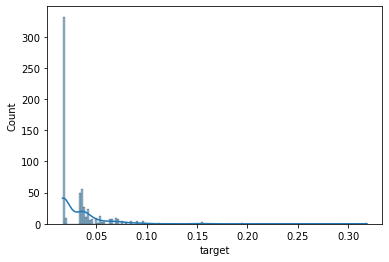

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.histplot(df_clean['target'], bins=150,kde=True)
#plt.xlim(0, 0.1)
plt.show()


In [10]:
#MRI = ["etiv", "nwbv", "asf"]
MRI = ["etiv", "nwbv"]
general_info = ["m/f", "age", "educ", "ses"]
exam = ["mmse"]

#df_clean = df_clean[MRI + ["target"]]
df_clean = df_clean[MRI+ general_info + ['target']]
#df_clean = df_clean[exam + ["target"]]
#df_clean = df_clean[exam + ["dementia"]]
df_clean

,etiv,nwbv,m/f,age,educ,ses,target
0,1344,0.743,0,74,2.0,3.0,0.017094
1,1147,0.810,0,55,4.0,1.0,0.017094
2,1454,0.708,0,73,4.0,3.0,0.036368
8,1636,0.689,1,74,5.0,2.0,0.016529
9,1321,0.827,0,52,3.0,2.0,0.016529
...,...,...,...,...,...,...,...
804,1693,0.694,1,82,16.0,1.0,0.035091
805,1688,0.675,1,86,16.0,1.0,0.037740
806,1319,0.801,0,61,13.0,2.0,0.016529
807,1327,0.796,0,63,13.0,2.0,0.016529


In [11]:
seed = 42
df_full_train, df_test = train_test_split(df_clean, test_size=0.2, random_state=seed)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=seed)

df_full_train = df_full_train.reset_index(drop=True)
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_full_train = df_full_train.target
y_train = df_train.target
y_val = df_val.target
y_test = df_test.target

df_full_train = df_full_train.drop(columns = ['target'])
df_train = df_train.drop(columns = ['target'])
df_val = df_val.drop(columns = ['target'])
df_test = df_test.drop(columns = ['target'])


In [14]:
dv = DictVectorizer(sparse=False)

train_dict = df_train.to_dict(orient='records') #turns the df into a dictionary
X_train = dv.fit_transform(train_dict)

val_dict = df_val.to_dict(orient='records')
X_val = dv.transform(val_dict) #note that this is transform instead of fit_transform


#X_train = df_train
#X_val = df_val

In [15]:
model = LogisticRegression(solver='liblinear', C=10, max_iter=1000, random_state=42)

model.fit(X_train, y_train)

ValueError: Unknown label type: 'continuous'

In [ ]:
y_pred = model.predict(X_val)
result = (y_pred==y_val)
sum(result)/len(result)

0.851063829787234